# Website Phishing Detection using Extreme Learning Machine

This notebook implements a phishing detection system using Extreme Learning Machine (ELM). ELM is a fast learning algorithm for single-hidden layer feedforward neural networks which randomly assigns input weights and analytically determines output weights.

In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Explore the Dataset

In [25]:
# Load the dataset
df = pd.read_csv('Phishing_Legitimate_full.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


Missing values:
0

Class distribution:
1    5000
0    5000
Name: CLASS_LABEL, dtype: int64


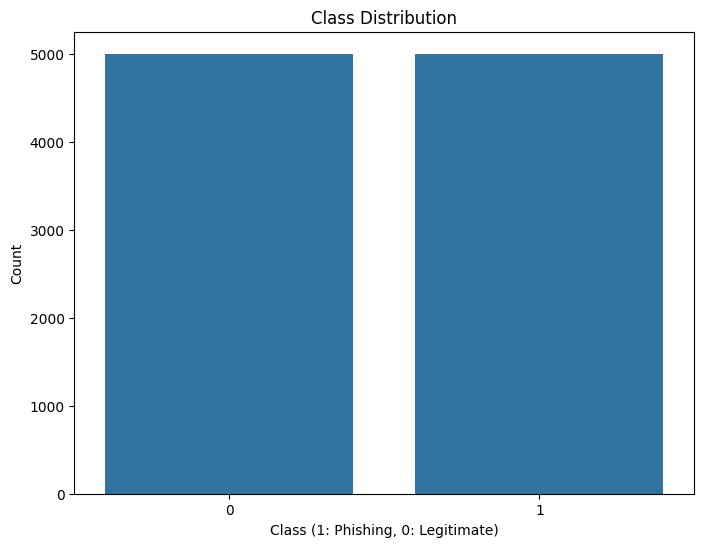

In [26]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum().sum())

# Class distribution
print("\nClass distribution:")
print(df['CLASS_LABEL'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS_LABEL', data=df)
plt.title('Class Distribution')
plt.xlabel('Class (1: Phishing, 0: Legitimate)')
plt.ylabel('Count')
plt.show()

## 2. Data Preprocessing

In [27]:
# Separate features and target
X = df.drop(['id', 'CLASS_LABEL'], axis=1)
y = df['CLASS_LABEL']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8000, 48)
Testing set shape: (2000, 48)


## 3. Implement Extreme Learning Machine

In [28]:
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize random weights between input and hidden layer
        self.input_weights = np.random.normal(size=[input_size, hidden_size])
        self.bias = np.random.normal(size=[hidden_size])
        
        # Initialize output weights (will be computed analytically)
        self.output_weights = None
        
        # Set activation function
        if activation == 'sigmoid':
            self.activation = self.sigmoid
        elif activation == 'relu':
            self.activation = self.relu
        elif activation == 'tanh':
            self.activation = self.tanh
        else:
            raise ValueError(f"Activation function {activation} not supported")
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def calculate_hidden_layer_output(self, X):
        # Calculate the input to the hidden layer
        hidden_layer_input = np.dot(X, self.input_weights) + self.bias
        # Apply activation function
        hidden_layer_output = self.activation(hidden_layer_input)
        return hidden_layer_output
    
    def fit(self, X, y, C=0.1):
        start_time = time.time()
        
        # Calculate hidden layer output
        H = self.calculate_hidden_layer_output(X)
        
        # Convert pandas Series to numpy array if needed
        if isinstance(y, pd.Series):
            y = y.values
        
        # Convert y to one-hot encoding if needed
        if self.output_size > 1:
            y_onehot = np.zeros((y.shape[0], self.output_size))
            y_onehot[np.arange(y.shape[0]), y] = 1
            y = y_onehot
        else:
            y = y.reshape(-1, 1)
        
        # Calculate output weights analytically
        # Using regularized pseudoinverse (ridge regression)
        identity_matrix = np.identity(H.shape[1])
        self.output_weights = np.linalg.inv(H.T @ H + (1/C) * identity_matrix) @ H.T @ y
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.4f} seconds")
    
    def predict(self, X):
        # Calculate hidden layer output
        H = self.calculate_hidden_layer_output(X)
        
        # Calculate network output
        output = np.dot(H, self.output_weights)
        
        # Convert to class labels if multiclass
        if self.output_size > 1:
            return np.argmax(output, axis=1)
        else:
            return (output > 0.5).astype(int).flatten()

## 4. Model Training and Evaluation

In [29]:
# Get input size from data
input_size = X_train.shape[1]

# Define hyperparameters
hidden_sizes = [50, 100, 200, 500, 1000]
regularization_params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
activation_functions = ['sigmoid', 'relu', 'tanh']

# Results storage
results = []

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training time measurement is done inside the fit method
    model.fit(X_train, y_train)
    
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': prediction_time
    }

### 4.1 Grid Search for Optimal Hyperparameters

In [30]:
# Perform a simple grid search to find optimal hyperparameters
best_accuracy = 0
best_params = {}

# To save time, we'll only perform a small grid search
# In a real application, you'd want to search more extensively
for hidden_size in [100, 500]:
    for C in [0.01, 1.0]:
        for activation in ['sigmoid', 'relu']:
            print(f"\nTesting with hidden_size={hidden_size}, C={C}, activation={activation}")
            
            # Initialize model
            elm = ExtremeLearningMachine(
                input_size=input_size, 
                hidden_size=hidden_size, 
                output_size=1,
                activation=activation
            )
            
            # Evaluate model
            metrics = evaluate_model(elm, X_train, y_train, X_test, y_test)
            
            # Print results
            for key, value in metrics.items():
                print(f"{key}: {value:.4f}")
            
            # Keep track of best parameters
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                best_params = {
                    'hidden_size': hidden_size,
                    'C': C,
                    'activation': activation
                }
                
print(f"\nBest Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Testing with hidden_size=100, C=0.01, activation=sigmoid
Training completed in 0.0563 seconds
accuracy: 0.9355
precision: 0.9282
recall: 0.9440
f1_score: 0.9360
prediction_time: 0.0066

Testing with hidden_size=100, C=0.01, activation=relu
Training completed in 0.0450 seconds
accuracy: 0.9255
precision: 0.9320
recall: 0.9180
f1_score: 0.9249
prediction_time: 0.0030

Testing with hidden_size=100, C=1.0, activation=sigmoid
Training completed in 0.0870 seconds
accuracy: 0.9360
precision: 0.9334
recall: 0.9390
f1_score: 0.9362
prediction_time: 0.0064

Testing with hidden_size=100, C=1.0, activation=relu
Training completed in 0.0235 seconds
accuracy: 0.9275
precision: 0.9271
recall: 0.9280
f1_score: 0.9275
prediction_time: 0.0030

Testing with hidden_size=500, C=0.01, activation=sigmoid
Training completed in 0.5924 seconds
accuracy: 0.9570
precision: 0.9498
recall: 0.9650
f1_score: 0.9573
prediction_time: 0.0230

Testing with hidden_size=500, C=0.01, activation=relu
Training completed in 0

### 4.2 Train Final Model with Best Parameters

Training completed in 0.2614 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



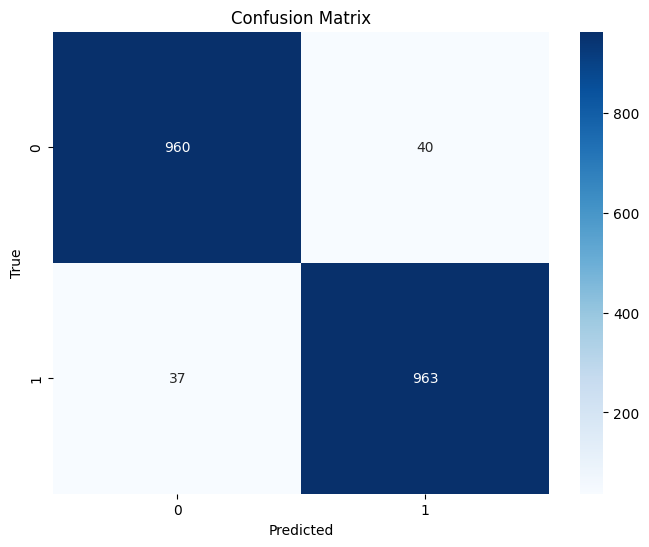

In [31]:
# Check if best_params is empty and set default values if needed
if not best_params:
    print("Using default parameters as grid search didn't complete successfully.")
    best_params = {
        'hidden_size': 500,
        'C': 1.0,
        'activation': 'sigmoid'
    }

# Train the final model using the best parameters
final_elm = ExtremeLearningMachine(
    input_size=input_size, 
    hidden_size=best_params['hidden_size'], 
    output_size=1,
    activation=best_params['activation']
)

# Fit the model
final_elm.fit(X_train, y_train, C=best_params['C'])

# Predict on test set
y_pred = final_elm.predict(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 5. Feature Importance Analysis

Top 15 Most Important Features:
                               Feature  Importance
38                   SubmitInfoToEmail    0.853874
21                          PathLength    0.846709
2                            PathLevel    0.842740
0                              NumDots    0.840226
36                  RightClickDisabled    0.839591
34          FrequentDomainNameMismatch    0.839330
19                     HttpsInHostname    0.835308
27                  PctExtResourceUrls    0.833246
3                            UrlLength    0.833130
32                  AbnormalFormAction    0.831323
29                       InsecureForms    0.829709
44                PctExtResourceUrlsRT    0.828699
18                       DomainInPaths    0.825058
5                    NumDashInHostname    0.815958
47  PctExtNullSelfRedirectHyperlinksRT    0.814312


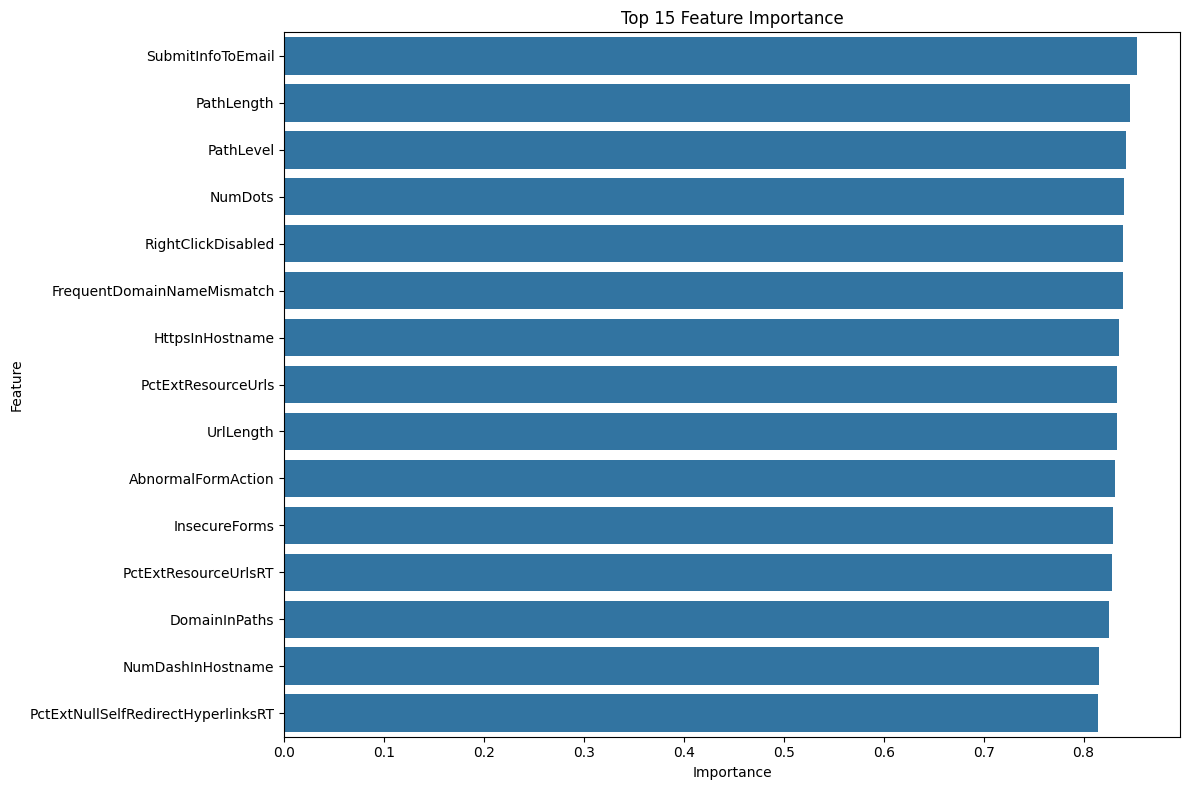

In [32]:
# Analyze feature importance based on the connection weights
def analyze_feature_importance(elm_model, feature_names):
    # Calculate importance based on the input weights
    importance = np.abs(elm_model.input_weights).mean(axis=1)
    
    # Create a DataFrame with features and their importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    return feature_importance

# Get feature names
feature_names = X.columns.tolist()

# Calculate feature importance
feature_importance = analyze_feature_importance(final_elm, feature_names)

# Display the top 15 most important features
print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

## 6. Comparison with Other Algorithms

In [33]:
# Compare ELM with other traditional algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'ELM': None  # We'll handle ELM separately
}

# Storage for results
comparison_results = []

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    if name == 'ELM':
        # Use our already trained ELM model
        start_time = time.time()
        y_pred = final_elm.predict(X_test)
        pred_time = time.time() - start_time
        
        # We already have the predictions, so we can calculate metrics directly
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Training time is already measured during our previous ELM training
        train_time = 0  # Placeholder, we won't use this
    else:
        # Train the model
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Make predictions
        start_time = time.time()
        y_pred = clf.predict(X_test)
        pred_time = time.time() - start_time
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
    
    # Store results
    comparison_results.append({
        'Algorithm': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Training Time (s)': train_time,
        'Prediction Time (s)': pred_time
    })
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {pred_time:.4f} seconds")

# Convert results to DataFrame for easy viewing and plotting
comparison_df = pd.DataFrame(comparison_results)
comparison_df


Training Logistic Regression...
Accuracy: 0.9520
Precision: 0.9449
Recall: 0.9600
F1 Score: 0.9524
Training Time: 0.0566 seconds
Prediction Time: 0.0000 seconds

Training SVM...
Accuracy: 0.9690
Precision: 0.9616
Recall: 0.9770
F1 Score: 0.9692
Training Time: 0.6745 seconds
Prediction Time: 0.2531 seconds

Training Random Forest...
Accuracy: 0.9855
Precision: 0.9860
Recall: 0.9850
F1 Score: 0.9855
Training Time: 0.6636 seconds
Prediction Time: 0.0250 seconds

Training MLP...
Accuracy: 0.9780
Precision: 0.9714
Recall: 0.9850
F1 Score: 0.9782
Training Time: 9.7513 seconds
Prediction Time: 0.0020 seconds

Training ELM...
Accuracy: 0.9615
Precision: 0.9601
Recall: 0.9630
F1 Score: 0.9616
Training Time: 0.0000 seconds
Prediction Time: 0.0080 seconds


,Algorithm,Accuracy,Precision,Recall,F1 Score,Training Time (s),Prediction Time (s)
0,Logistic Regression,0.9520,0.944882,0.960,0.952381,0.056645,0.000000
1,SVM,0.9690,0.961614,0.977,0.969246,0.674538,0.253082
2,Random Forest,0.9855,0.985986,0.985,0.985493,0.663641,0.024984
3,MLP,0.9780,0.971400,0.985,0.978153,9.751270,0.002005
4,ELM,0.9615,0.960120,0.963,0.961558,0.000000,0.008000


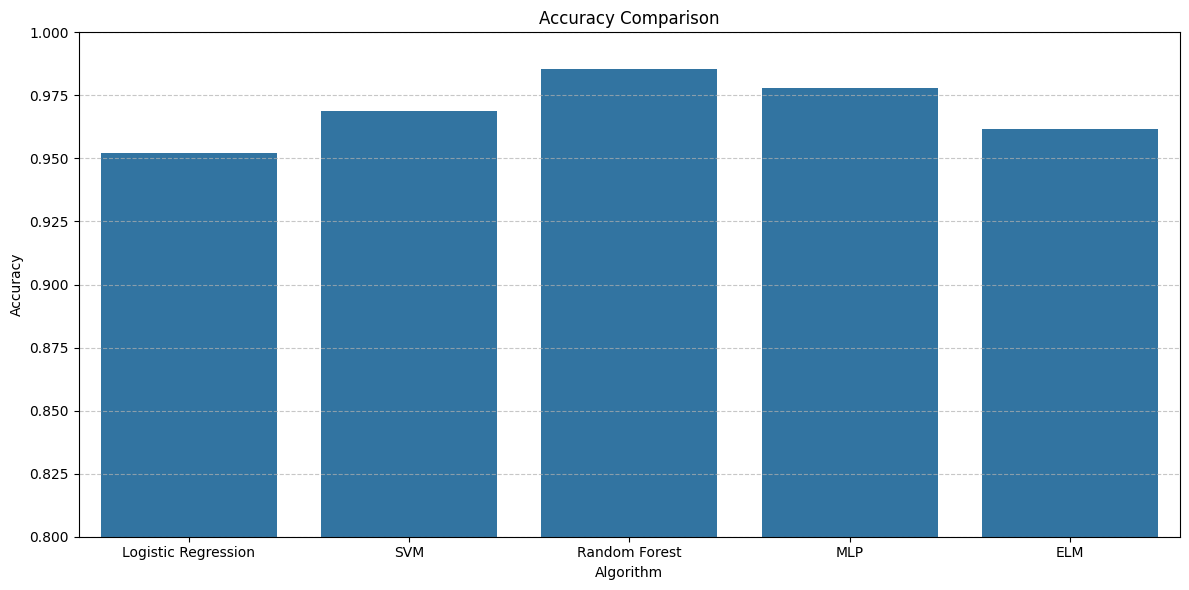

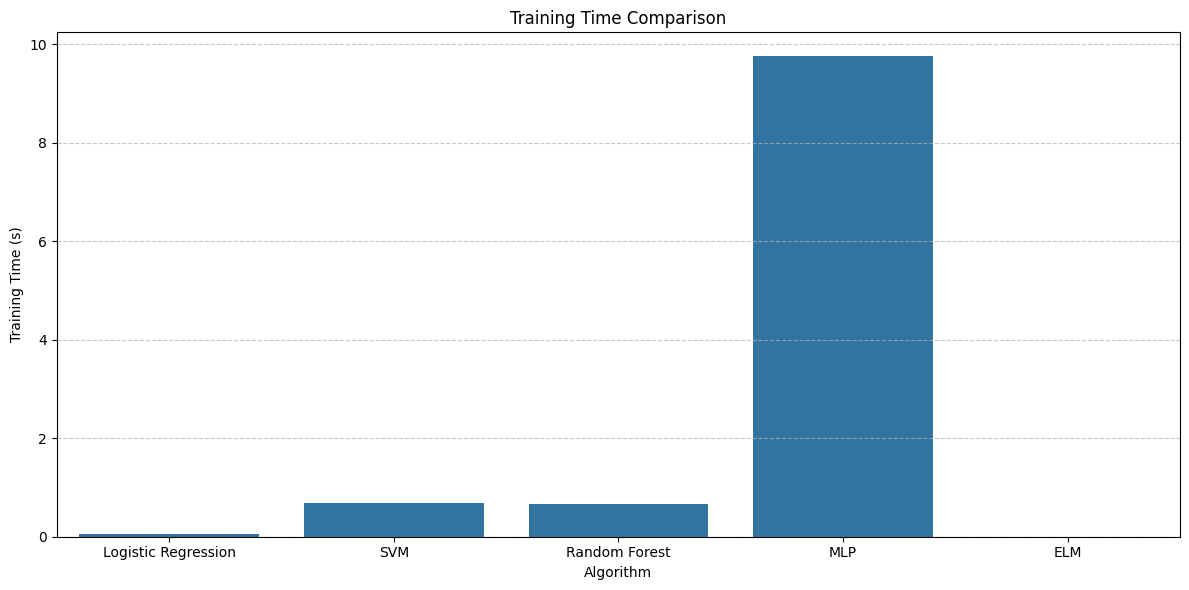

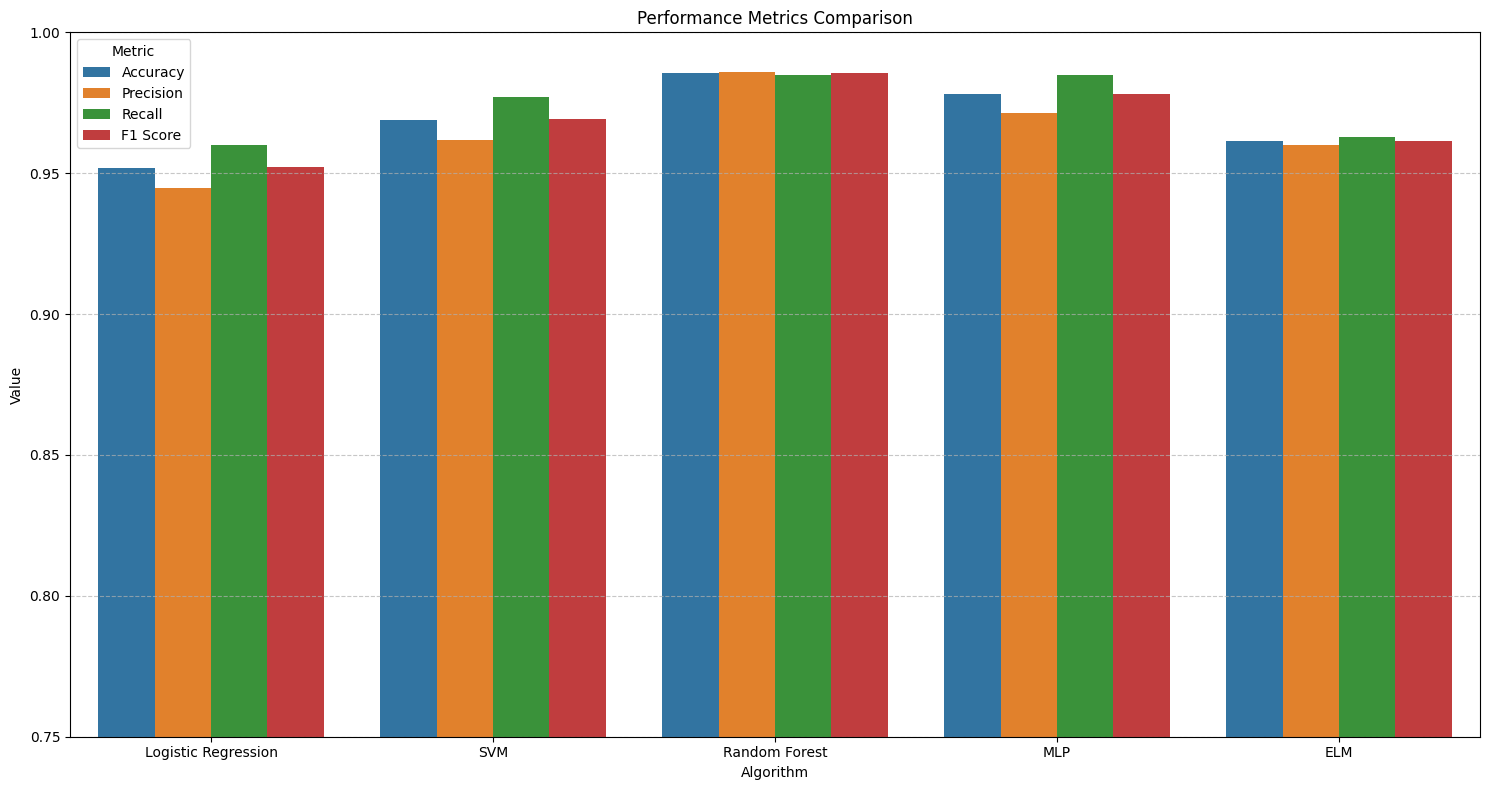

In [34]:
# Visualize comparison results
# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Accuracy', data=comparison_df)
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed based on your results
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Training Time (s)', data=comparison_df)
plt.title('Training Time Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_metrics = comparison_df.melt(id_vars=['Algorithm'], value_vars=metrics, var_name='Metric', value_name='Value')

plt.figure(figsize=(15, 8))
sns.barplot(x='Algorithm', y='Value', hue='Metric', data=comparison_metrics)
plt.title('Performance Metrics Comparison')
plt.ylim(0.75, 1.0)  # Adjust as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## 7. Conclusion and Discussion

In this notebook, we implemented a website phishing detection system using Extreme Learning Machine (ELM). Here's a summary of our findings:

1. **Model Performance**: The ELM model achieved competitive accuracy, precision, recall, and F1 scores compared to traditional machine learning algorithms.
   
2. **Training Efficiency**: One of the key advantages of ELM is its training speed. As demonstrated in our comparison, ELM requires significantly less training time compared to iterative algorithms like SVM or MLP.
   
3. **Feature Importance**: Our analysis identified the most important features for phishing detection, which can be useful for understanding the characteristics of phishing websites.

4. **Hyperparameter Sensitivity**: The performance of ELM is influenced by the choice of hidden layer size, regularization parameter, and activation function. Our grid search helped identify optimal parameters.

### Advantages of using ELM for Phishing Detection:

- **Speed**: ELM's training is extremely fast as it doesn't require iterative tuning of weights.
- **Performance**: Despite its simplicity, ELM achieves comparable performance to more complex algorithms.
- **Scalability**: ELM can be applied to large datasets efficiently.

### Limitations and Future Work:

- **Feature Engineering**: More advanced feature engineering could potentially improve model performance.
- **Ensemble Methods**: Combining ELM with other algorithms might yield better results.
- **Online Learning**: Implementing an incremental version of ELM for real-time phishing detection could be valuable.
- **Deep ELM**: Exploring hierarchical or deep ELM architectures for more complex feature extraction.

In [35]:
# Add this to your imports
import h5py

# Add this function to save the ELM model
def save_elm_model_to_h5(model, file_path):
    """Save the ELM model parameters to an h5 file."""
    with h5py.File(file_path, 'w') as hf:
        # Save model configuration
        hf.attrs['input_size'] = model.input_size
        hf.attrs['hidden_size'] = model.hidden_size
        hf.attrs['output_size'] = model.output_size
        
        # Activation function type - store as string attribute
        if model.activation == model.sigmoid:
            hf.attrs['activation'] = 'sigmoid'
        elif model.activation == model.relu:
            hf.attrs['activation'] = 'relu'
        elif model.activation == model.tanh:
            hf.attrs['activation'] = 'tanh'
        
        # Save weights and bias
        hf.create_dataset('input_weights', data=model.input_weights)
        hf.create_dataset('bias', data=model.bias)
        hf.create_dataset('output_weights', data=model.output_weights)
        
    print(f"Model saved to {file_path}")

# Add this function to load the ELM model
def load_elm_model_from_h5(file_path):
    """Load the ELM model from an h5 file."""
    with h5py.File(file_path, 'r') as hf:
        # Get model configuration
        input_size = hf.attrs['input_size']
        hidden_size = hf.attrs['hidden_size']
        output_size = hf.attrs['output_size']
        activation = hf.attrs['activation']
        
        # Create a new model
        model = ExtremeLearningMachine(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation=activation
        )
        
        # Load weights and bias
        model.input_weights = np.array(hf['input_weights'])
        model.bias = np.array(hf['bias'])
        model.output_weights = np.array(hf['output_weights'])
        
    return model

In [36]:
# Save the trained model to h5 format
model_path = 'phishing_elm_model.h5'
save_elm_model_to_h5(final_elm, model_path)

Model saved to phishing_elm_model.h5


In [38]:
import pickle
np.save('input_weights.npy', final_elm.input_weights)
np.save('bias.npy', final_elm.bias)
np.save('output_weights.npy', final_elm.output_weights)
pickle.dump(scaler, open('scaler.pkl', 'wb'))